### Merging datasets (ML paradigm + PLC phase + ML method)

- **ML category**  
  ML paradigm classification **keywords only** 
  *(source: `keywords`)*

- **PLC phase**  
  Semantic PLC classification  
  *(source: `semantic_analysis_ext_desc`)*

- **ML method**  
  Machine learning methods extracted from abstracts using regex-based matching  
  *(source: `regex_scispacy`)*

Datasets are merged on **DOI**.  
This means that abstracts (DOIs) without data in any of the datasets are not included.


In [1]:
# Imports

import pandas as pd
from pathlib import Path
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [ ]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "total_results"

ml_methods_path = processed_abstracts_path / "regex_scispacy/abstracts_with_ml_methods_regex.csv"
ml_category_path = processed_abstracts_path / "keywords/abstracts_with_labels.csv"
production_category_path = processed_abstracts_path / "semantic_analysis_ext_desc/abstracts_min_phases.csv"
prod_cluster_keywords_path = processed_abstracts_path / "semantic_analysis_ext_desc/keywords.json"

# Ensure directories exist
for p in [processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load Data

# ML-methods
df_ml_methods = pd.read_csv(ml_methods_path)

# ML-category
df_ml_category = pd.read_csv(ml_category_path)

# Production category
df_prod_category = pd.read_csv(production_category_path)

# Production cluster keywords
with open(prod_cluster_keywords_path, "r", encoding="utf-8") as f:
    prod_cluster_keywords = json.load(f)

In [4]:
# Check columns
print(df_ml_methods.columns)
print(df_ml_category.columns)
print(df_prod_category.columns)

Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'ml_methods_regex', 'method_count'],
      dtype='object')
Index(['query_id', 'doi', 'clean_abs', 'is_supervised', 'is_unsupervised',
       'is_reinforcement'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs', 'phase'], dtype='object')


In [5]:
# Check head of each dataset
df_ml_methods.head(2)

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count
0,ml_end_of_life,2-s2.0-105008951371,10.3390/su17125511,Review and Novel Framework with Hui–Walter Met...,© 2025 by the authors.Consumers’ growing inter...,Consumers’ growing interest in sustainability ...,[],0
1,ml_end_of_life,2-s2.0-85174142475,10.3390/asi6050076,Measuring Carbon in Cities and Their Buildings...,© 2023 by the authors.According to the Europea...,"According to the European Green Deal, excessiv...",['Linear Regression'],1


In [6]:
df_ml_category.head(2)

,query_id,doi,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_end_of_life,10.1016/B978-0-443-33740-6.00012-8,All rights reserved.As the production and cons...,False,False,False
1,ml_end_of_life,10.1080/19397038.2025.2563271,"Published by Informa UK Limited, trading as Ta...",False,False,False


In [7]:
df_prod_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,phase
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,4
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",4


In [8]:
df_ml_category.info()
print()
df_ml_methods.info()
print()
df_prod_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   query_id          33130 non-null  object
 1   doi               33129 non-null  object
 2   clean_abs         33129 non-null  object
 3   is_supervised     33130 non-null  bool  
 4   is_unsupervised   33130 non-null  bool  
 5   is_reinforcement  33130 non-null  bool  
dtypes: bool(3), object(3)
memory usage: 873.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   query_id          33130 non-null  object
 1   eid               33130 non-null  object
 2   doi               33129 non-null  object
 3   title             33130 non-null  object
 4   abstract          33130 non-null  object
 5   clean_abs         33129 non-null  obj

In [9]:
# Config

ID_COL = "doi"
RAW_ML_METHOD_COL = "ml_methods_regex"
ML_METHOD_COL = "ml_method"
ML_CAT_COL = "ml_category"
RAW_PROD_CAT_COL = "phase"
PROD_CAT_COL = "phase"



In [10]:
# Build ML categories per axis

ml_pred_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

ml_long = (
    df_ml_category[[ID_COL] + ml_pred_cols]
    .melt(id_vars=ID_COL, var_name="ml_axis", value_name="is_active")
)

ml_long = ml_long[ml_long["is_active"] == 1].copy()

ml_long[ML_CAT_COL] = ml_long["ml_axis"].map({
    "is_supervised": "supervised",
    "is_unsupervised": "unsupervised",
    "is_reinforcement": "reinforcement",
})

ml_long = ml_long[[ID_COL, ML_CAT_COL]]

ml_long[ML_CAT_COL].value_counts()


ml_category
supervised       11798
unsupervised      3754
reinforcement     1762
Name: count, dtype: int64

In [11]:
# Parse ML method list column

def parse_method_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s or s == "[]":
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except (ValueError, SyntaxError):
        return [s]

df_ml_methods["ml_methods_list"] = df_ml_methods[RAW_ML_METHOD_COL].apply(parse_method_list)
df_ml_methods[[RAW_ML_METHOD_COL, "ml_methods_list"]].head(5)


,ml_methods_regex,ml_methods_list
0,[],[]
1,['Linear Regression'],[Linear Regression]
2,"['Linear Regression', 'Support Vector Regressi...","[Linear Regression, Support Vector Regression,..."
3,['Neural Network'],[Neural Network]
4,[],[]


In [12]:
# Explode methods to one row per doi–method

df_methods_long = (
    df_ml_methods[[ID_COL, "ml_methods_list"]]
    .explode("ml_methods_list")
    .rename(columns={"ml_methods_list": ML_METHOD_COL})
)

df_methods_long = df_methods_long[
    df_methods_long[ML_METHOD_COL].notna()
    & (df_methods_long[ML_METHOD_COL].astype(str).str.strip() != "")
]

df_methods_long.head()


,doi,ml_method
1,10.3390/asi6050076,Linear Regression
2,10.1016/j.resconrec.2023.107073,Linear Regression
2,10.1016/j.resconrec.2023.107073,Support Vector Regression
2,10.1016/j.resconrec.2023.107073,Gradient Boosting
3,10.1016/j.dche.2023.100103,Neural Network


In [13]:
# Production categories

df_prod_long = (
    df_prod_category[[ID_COL, RAW_PROD_CAT_COL]]
    .rename(columns={RAW_PROD_CAT_COL: PROD_CAT_COL})
)

df_prod_long.head()


,doi,phase
0,10.1016/B978-0-443-33740-6.00012-8,4
1,10.1080/19397038.2025.2563271,4
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,4
3,10.1188/23.CJON.595-601,1
4,10.1039/d3va00106g,4


In [14]:
# Full long table: one row per doi–method–ml_category–prod_category

df_all = (
    df_methods_long[[ID_COL, ML_METHOD_COL]]
    .merge(ml_long, on=ID_COL, how="inner")
    .merge(df_prod_long, on=ID_COL, how="inner")
)

print(df_all.shape)
df_all.head()


(28948, 4)


,doi,ml_method,ml_category,phase
0,10.3390/asi6050076,Linear Regression,supervised,1
1,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,4
2,10.1016/j.resconrec.2023.107073,Support Vector Regression,supervised,4
3,10.1016/j.resconrec.2023.107073,Gradient Boosting,supervised,4
4,10.30638/eemj.2023.018,Neural Network,supervised,4


In [15]:
# Quick sanity check and neural network count

print("ML categories:")
print(df_all[ML_CAT_COL].value_counts())

print("\nProduction categories:")
print(df_all[PROD_CAT_COL].value_counts())

print("\nExample methods:")
print(df_all[ML_METHOD_COL].value_counts().head(20))


ML categories:
ml_category
supervised       22169
unsupervised      5124
reinforcement     1655
Name: count, dtype: int64

Production categories:
phase
3    17237
4     5607
2     4471
1     1633
Name: count, dtype: int64

Example methods:
ml_method
Neural Network                  4135
Random Forest                   3365
Support Vector Machine          2462
Decision Tree                   1564
Gradient Boosting               1274
XGBoost                         1205
Linear Regression                988
Principal Component Analysis     957
K-Nearest Neighbors              945
Convolutional Neural Network     912
Support Vector Regression        764
LSTM                             719
Autoencoder                      619
Logistic Regression              547
K-Means                          541
Bayesian Method                  539
Genetic Algorithm                488
Particle Swarm Optimization      433
Gaussian Process Regression      423
Multi-Layer Perceptron           403
Name: coun

In [16]:
# Counts per (ML category, production category, method)

group_cols = [ML_CAT_COL, PROD_CAT_COL, ML_METHOD_COL]

method_counts = (
    df_all
    .groupby(group_cols)[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
)

method_counts.head()


,ml_category,phase,ml_method,n_articles
0,reinforcement,1,ARIMA,1
1,reinforcement,1,Actor-Critic,3
2,reinforcement,1,Autoencoder,2
3,reinforcement,1,Bayesian Method,6
4,reinforcement,1,Convolutional Neural Network,3


In [17]:
# Total unique articles per (ML category, production category)

cell_totals = (
    df_all
    .groupby([ML_CAT_COL, PROD_CAT_COL])[ID_COL]
    .nunique()
    .reset_index(name="cell_total")
)

cell_totals.head()


,ml_category,phase,cell_total
0,reinforcement,1,128
1,reinforcement,2,287
2,reinforcement,3,326
3,reinforcement,4,135
4,supervised,1,531


In [18]:
# Order categories by frequency of unique articles

ml_cat_order = (
    df_all
    .groupby(ML_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

prod_cat_order = (
    df_all
    .groupby(PROD_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

ml_cat_order, prod_cat_order


(['supervised', 'unsupervised', 'reinforcement'], [3, 2, 4, 1])

In [19]:
# Top-k methods per cell

TOP_K = 3

method_counts["rank_in_cell"] = (
    method_counts
    .groupby([ML_CAT_COL, PROD_CAT_COL])["n_articles"]
    .rank(method="dense", ascending=False)
)

top_methods = (
    method_counts[method_counts["rank_in_cell"] <= TOP_K]
    .merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL], how="left")
    .sort_values([ML_CAT_COL, PROD_CAT_COL, "n_articles"], ascending=[True, True, False])
)

top_methods.head(10)


,ml_category,phase,ml_method,n_articles,rank_in_cell,cell_total
1,reinforcement,1,Neural Network,42,1.0,128
0,reinforcement,1,Deep Reinforcement Learning,33,2.0,128
2,reinforcement,1,Random Forest,17,3.0,128
3,reinforcement,2,Deep Reinforcement Learning,95,1.0,287
4,reinforcement,2,Neural Network,92,2.0,287
5,reinforcement,2,Q-Learning,49,3.0,287
6,reinforcement,3,Neural Network,110,1.0,326
7,reinforcement,3,Q-Learning,50,2.0,326
8,reinforcement,3,Random Forest,38,3.0,326
10,reinforcement,4,Neural Network,41,1.0,135


In [20]:
# Build 2D map summary

def summarize_cell(group):
    total = int(group["cell_total"].iloc[0])
    methods_str = ", ".join(
        f"{m} ({int(n)})"
        for m, n in zip(group[ML_METHOD_COL], group["n_articles"])
    )
    return pd.Series({"summary": f"n={total}; top: {methods_str}"})

cell_summary = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_cell)
    .reset_index()
)

cell_summary.head()


/tmp/ipykernel_769451/602492248.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_cell)


,ml_category,phase,summary
0,reinforcement,1,"n=128; top: Neural Network (42), Deep Reinforc..."
1,reinforcement,2,"n=287; top: Deep Reinforcement Learning (95), ..."
2,reinforcement,3,"n=326; top: Neural Network (110), Q-Learning (..."
3,reinforcement,4,"n=135; top: Neural Network (41), Deep Reinforc..."
4,supervised,1,"n=531; top: Random Forest (231), Neural Networ..."


In [21]:
# Pivot to 2D grid

summary_grid = cell_summary.pivot(
    index=ML_CAT_COL,
    columns=PROD_CAT_COL,
    values="summary"
)

summary_grid = summary_grid.reindex(index=ml_cat_order, columns=prod_cat_order)

summary_grid


phase,3,2,4,1
ml_category,,,,
supervised,"n=5191; top: Random Forest (1679), Neural Netw...","n=1553; top: Neural Network (705), Random Fore...","n=1671; top: Neural Network (665), Random Fore...","n=531; top: Random Forest (231), Neural Networ..."
unsupervised,"n=1556; top: Neural Network (437), Principal C...","n=285; top: Neural Network (95), Autoencoder (...","n=384; top: Neural Network (128), Principal Co...","n=114; top: Neural Network (29), K-Means (25),..."
reinforcement,"n=326; top: Neural Network (110), Q-Learning (...","n=287; top: Deep Reinforcement Learning (95), ...","n=135; top: Neural Network (41), Deep Reinforc...","n=128; top: Neural Network (42), Deep Reinforc..."


In [56]:
# Manual mapping: production phases to short labels (with phase number)
prod_cluster_label_map = {
    1: "1 - planning",
    2: "2 - production",
    3: "3 - optimization",
    4: "4 - re-use"
}

# Map each phase value to its label, fallback to the phase value if unknown
df_all["phase_label"] = df_all["phase"].map(prod_cluster_label_map).fillna(df_all["phase"].astype(str))

prod_cluster_label_map


{1: '1 - planning',
 2: '2 - production',
 3: '3 - optimization',
 4: '4 - re-use'}

In [57]:
bubble_df = cell_summary.merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL])

bubble_df["prod_cluster_label"] = bubble_df[PROD_CAT_COL].map(prod_cluster_label_map)

fig = px.scatter(
    bubble_df,
    x="prod_cluster_label",
    y=ML_CAT_COL,
    size="cell_total",
    # text="summary",
    size_max=100
)

fig.update_traces(textposition="top center")
# fig.update_layout(
#     width=1800,  
#     height=600   
# )
fig.show()


In [58]:
# Label map from cluster id to short description
def make_cluster_label(cid):
    cid_str = str(cid)
    words = prod_cluster_keywords.get(cid_str, [])[:4]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

prod_label_map = {cid: make_cluster_label(cid) for cid in prod_cat_order}
prod_label_to_id = {v: k for k, v in prod_label_map.items()}

# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)


In [59]:
# Widgets

ml_cat_dropdown = widgets.Dropdown(
    options=ml_cat_order,
    description="ML cat",
    layout=widgets.Layout(width="300px")
)

prod_dropdown = widgets.Dropdown(
    options=[prod_label_map[c] for c in prod_cat_order],
    description="Prod",
    layout=widgets.Layout(width="400px")
)


In [60]:
# Callback for dashboard

def update_dashboard(ml_cat, prod_label, top_k=15):
    prod_id = prod_label_to_id[prod_label]
    
    subset = (
        method_counts
        .query(f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id")
        .sort_values("n_articles", ascending=False)
    )
    
    if subset.empty:
        print(f"No articles for cell: {ml_cat} × {prod_label}")
        return
    
    cell_n = int(
        cell_totals.query(
            f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id"
        )["cell_total"].iloc[0]
    )
    
    print(f"Cell: {ml_cat} × {prod_label}")
    print(f"Unique articles in cell: {cell_n}")
    print("\nTop methods:")
    
    display(subset[[ML_METHOD_COL, "n_articles"]].head(top_k))
    
    top_plot = subset.head(top_k)
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_plot[ML_METHOD_COL].astype(str), top_plot["n_articles"])
    plt.gca().invert_yaxis()
    plt.xlabel("Number of articles")
    plt.title("Top methods in selected cell")
    plt.tight_layout()
    plt.show()


In [61]:
# Bind widgets to callback

ui = widgets.VBox([ml_cat_dropdown, prod_dropdown])

out = widgets.interactive_output(
    update_dashboard,
    {"ml_cat": ml_cat_dropdown, "prod_label": prod_dropdown}
)

display(ui, out)


Output()

In [62]:
# ML category flags per article
ml_flag_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

df_ml_flags = df_ml_category[[ID_COL] + ml_flag_cols].copy()

# Count active categories
df_ml_flags["n_active"] = df_ml_flags[ml_flag_cols].sum(axis=1)

# Remove "none" (articles with zero ML categories)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] > 0].copy()

# Multi-label flags
df_ml_flags["is_multi"] = df_ml_flags["n_active"] > 1
df_ml_flags["multi_type"] = df_ml_flags["n_active"].map({
    1: "single",
    2: "double",
    3: "triple"
})

df_ml_flags["multi_type"].value_counts()


multi_type
single    12840
double     2093
triple       96
Name: count, dtype: int64

In [63]:
# Join ML flags with production cluster
ml_prod_flags = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

# Compute share per cluster
share_multi_by_prod = (
    ml_prod_flags
    .groupby(PROD_CAT_COL)["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

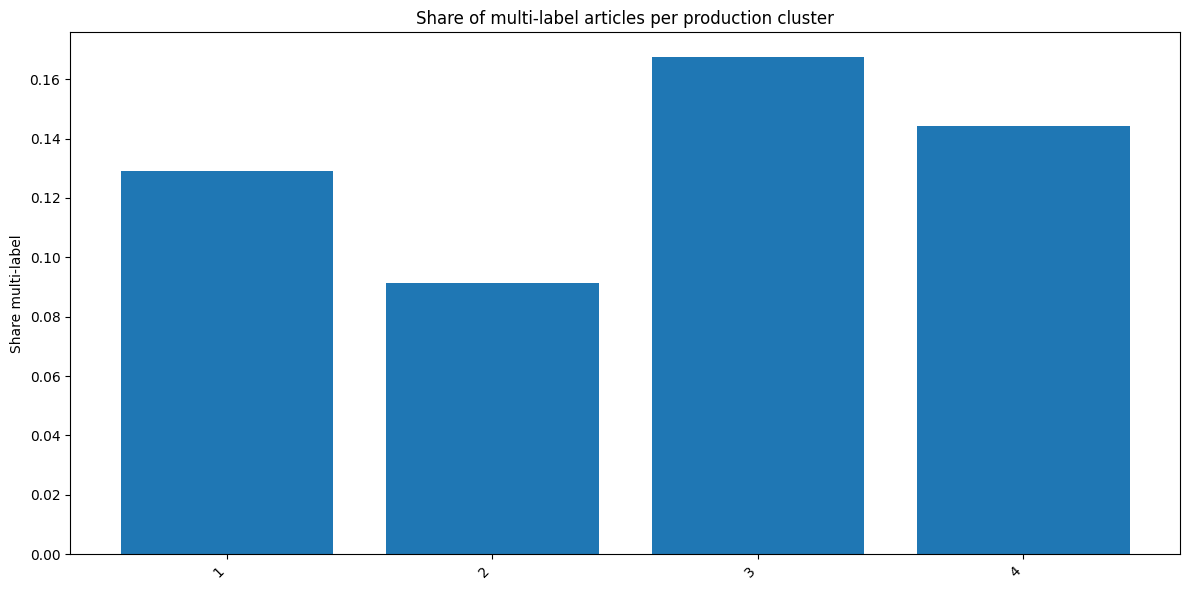

In [64]:
plot_df = share_multi_by_prod.copy()
plot_df["prod_label"] = plot_df[PROD_CAT_COL].map(prod_label_map)

plt.figure(figsize=(12, 6))
plt.bar(plot_df["prod_label"], plot_df["share_multi"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share multi-label")
plt.title("Share of multi-label articles per production cluster")
plt.tight_layout()
plt.show()


In [65]:
ml_axis_long = df_ml_flags.melt(
    id_vars=[ID_COL, "is_multi"],
    value_vars=ml_flag_cols,
    var_name="ml_axis",
    value_name="is_active"
)

ml_axis_long = ml_axis_long[ml_axis_long["is_active"] == 1].copy()

ml_axis_long["ml_axis"] = ml_axis_long["ml_axis"].map({
    "is_supervised": "supervised",
    "is_unsupervised": "unsupervised",
    "is_reinforcement": "reinforcement"
})

share_multi_by_axis = (
    ml_axis_long
    .groupby("ml_axis")["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

share_multi_by_axis


,ml_axis,share_multi
0,reinforcement,0.271283
1,supervised,0.178674
2,unsupervised,0.502930


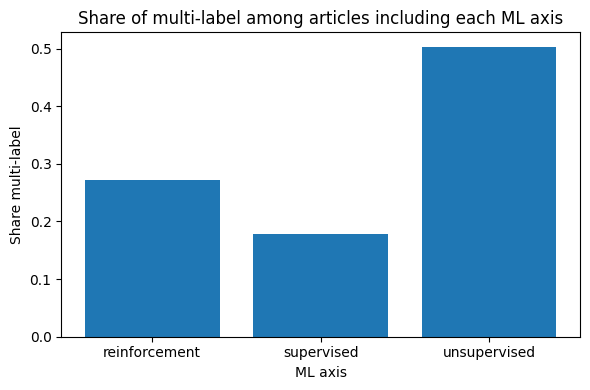

In [66]:
# Bar plot: share of multi-label among articles that include each axis

plt.figure(figsize=(6, 4))
plt.bar(share_multi_by_axis["ml_axis"], share_multi_by_axis["share_multi"])
plt.ylabel("Share multi-label")
plt.xlabel("ML axis")
plt.title("Share of multi-label among articles including each ML axis")
plt.tight_layout()
plt.show()


In [67]:
# Keep only multi-label (>=2)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] >= 2].copy()

def make_combo(row):
    parts = []
    if row["is_supervised"] == 1:
        parts.append("supervised")
    if row["is_unsupervised"] == 1:
        parts.append("unsupervised")
    if row["is_reinforcement"] == 1:
        parts.append("reinforcement")
    return "+".join(parts)

df_ml_flags["ml_combo"] = df_ml_flags.apply(make_combo, axis=1)


df_combo_prod = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

combo_by_prod = (
    df_combo_prod
    .groupby([PROD_CAT_COL, "ml_combo"])[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
    .sort_values(["phase", "n_articles"], ascending=[True, False])
)

top3_combo_prod = (
    combo_by_prod
    .sort_values("n_articles", ascending=False)
    .head(3)
)

top3_combo_prod



,phase,ml_combo,n_articles
9,3,supervised+unsupervised,1168
13,4,supervised+unsupervised,297
5,2,supervised+unsupervised,183


In [68]:
df_ml_flags_all = df_ml_category[[ID_COL] + ml_flag_cols].copy()
df_ml_flags_all["n_active"] = df_ml_flags_all[ml_flag_cols].sum(axis=1)

# Separate none vs labeled
none_df = df_ml_flags_all[df_ml_flags_all["n_active"] == 0].copy()
labeled_df = df_ml_flags_all[df_ml_flags_all["n_active"] > 0].copy()

print("Total none:", len(none_df))
print("Total labeled:", len(labeled_df))


Total none: 18101
Total labeled: 15029


In [69]:
# Count how many total articles per production cluster
total_per_cluster = (
    df_prod_long[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("total_cluster")
)

# Count none-articles per cluster
none_prod = none_df.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

none_per_cluster = (
    none_prod[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("none_count")
)

# Combine counts
none_stats = (
    pd.concat([none_per_cluster, total_per_cluster], axis=1)
    .fillna(0)
)

# Compute share
none_stats["none_share"] = none_stats["none_count"] / none_stats["total_cluster"]

# Reorder columns
none_stats = none_stats[
    ["none_count", "total_cluster", "none_share"]
]

none_stats


,none_count,total_cluster,none_share
phase,,,
1,1666,2672,0.623503
2,5913,8892,0.664980
3,7219,15580,0.463350
4,3303,5986,0.551788


In [70]:
# Prepare method lists
df_methods = df_ml_methods[[ID_COL, "ml_methods_list"]].copy()
df_methods["n_methods"] = df_methods["ml_methods_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Merge into none vs labeled
none_methods = none_df.merge(df_methods, on=ID_COL, how="left")
labeled_methods = labeled_df.merge(df_methods, on=ID_COL, how="left")

print("Avg methods (none):", none_methods["n_methods"].mean())
print("Avg methods (labeled):", labeled_methods["n_methods"].mean())

print("\nMedian methods (none):", none_methods["n_methods"].median())
print("Median methods (labeled):", labeled_methods["n_methods"].median())

# Share with zero methods
none_zero_share = (none_methods["n_methods"] == 0).mean()
labeled_zero_share = (labeled_methods["n_methods"] == 0).mean()

print("\nShare with zero methods (none):", none_zero_share)
print("Share with zero methods (labeled):", labeled_zero_share)


Avg methods (none): 0.4313573835699685
Avg methods (labeled): 1.6544680284782753

Median methods (none): 0.0
Median methods (labeled): 1.0

Share with zero methods (none): 0.7084138997845423
Share with zero methods (labeled): 0.2977576685075521
